In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as platches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from tqdm import tqdm
import imageio
import imgaug.augmenters as iaa 
import tensorflow as tf

sys.path.append('./Mask_RCNN/')
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config

In [2]:
print('Keras version: {}\nTensoflow version: {}\nTensorflow keras version: {}'
      .format(tf.__version__, tf.__version__, tf.keras.__version__))

Keras version: 2.4.0
Tensoflow version: 2.4.0
Tensorflow keras version: 2.4.0


In [3]:
# Original Image Dimensions
HEIGHT = 520
WIDTH = 704
SHAPE = (HEIGHT, WIDTH)

# Target image dimension which are divisable by 64 as required by the Mask-RCNN model
HEIGHT_TARGET = 64 * 9  # = 576
WIDTH_TARGET = 64 * 11  # = 704
SHAPE_TARGET = (HEIGHT_TARGET, WIDTH_TARGET)

class CellConfig(Config):
    """
    Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides value specific
    to the cigaratte butts dataset.
    """

    NAME = '050522-all-09th-train'
    
    GPU_COUNT = 1
    
    # No. classes
    NUM_CLASSES = 4
    
    # Image dimensions
    IMAGE_RESIZE_MODE = "none"
    IMAGE_MIN_DIM = HEIGHT_TARGET
    IMAGE_MAX_DIM = WIDTH_TARGET
    IMAGE_SHAPE = [HEIGHT_TARGET, WIDTH_TARGET, 3]
    
    # Dont train Batch Normalization because of small batch size
    # There are too few samples to correctly train the normalization
    TRAIN_BN = False
    
    # Learing rate
    LEARNING_RATE = 0.001
    #WEIGHT_DECAY = 0.0
    #N_WARMUP_STEPS = 2
    LR_SCHEDULE = False
    
    # Mini mask
    USE_MINI_MASK = False
    
config = CellConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  704
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  576
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [704 704   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
LR_SCHEDULE                    False
MASK_POOL_SIZE        

In [4]:
class CellDataset(utils.Dataset):
    def __init__(self, pred_fg=True):
        super().__init__()
        self._astro_ids, self._cort_ids, self._shsy5y_ids = [], [], []
    
    def load_data(self,image_ids, image_group):  
        # Add class
        [self.add_class('cell', i+1, name) for i, name in enumerate(CELL_NAMES)]
        
        # Add image
        for idx, image_id in enumerate(tqdm(image_ids)):
            mosaic_augment = False
            cell_label = ID2CELL_LABEL[image_id] - 1
            mosaic_augment = True if (CELL_NAMES_DICT['shsy5y'] != cell_label) else False            
            label = ID2CELL_LABEL[image_id]
            
            # Add to list type id to use later
            if cell_label == CELL_NAMES_DICT['astro']:
                self._astro_ids.append(idx)
            elif cell_label == CELL_NAMES_DICT['cort']:
                self._cort_ids.append(idx)
            elif cell_label == CELL_NAMES_DICT['shsy5y']:
                self._shsy5y_ids.append(idx)
            
            self.add_image('cell', image_id=image_id, 
                            path='./{}/{}.png'.format(image_group, image_id), 
                            label=label, mosaic_augment=mosaic_augment)
        
                    
    def load_mask(self, image_id):
        """
        Load instance masks for the given image.
        Mask-RCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for.
        Return:
            masks: A bool array of shape [height, width, instance count] with 
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        
        info = self.image_info[image_id]
        image_id = info['id']
        
        # Get masks by image_id
        masks = rle_decode_by_image_id(image_id)
        masks = pad_image(masks, 0)
        
        # Get label
        _, _, size = masks.shape
        label = info['label']
        class_ids = np.full(size, label, dtype=np.int32)
        
        return masks, class_ids
    
    def mosaic(self, image_id, SHAPE=(HEIGHT, WIDTH), seed=None):
        """
        Apply mosaice augmentation for the given image. The mechanism
        of this technique is merge 4 images then random crop to expected
        size.
        Args:
            image_id: The id of the image to load 
        Return:
            image: [height, width, 3]. 
            masks: [height, width, instance_count]. 
            class_ids: [instance_count].
        """        
        
        # Choosing 3 images which have same cell type to merge,
        # In order to balance the number of instances, we just
        # apply mosaic augmentation for astro and cort type
        image_info = self.image_info[image_id]
        label = image_info['label']
        if label == CELL_NAMES_DICT['astro'] + 1:
            image_ids = np.random.choice(self._astro_ids, 3, replace=False)
        elif label == CELL_NAMES_DICT['cort'] + 1:
            image_ids = np.random.choice(self._cort_ids, 3, replace=False)
        else:
            return
        image_ids = np.append(image_ids, image_id)
        
        # Split images to stack
        stack_01_ids, stack_02_ids = image_ids[:2], image_ids[2:]
    
        # Load image and unpad (the image padded so we have to unpad back to the original size)
        stack_01_imgs = [unpad_image(self.load_image(image_id)) for image_id in stack_01_ids]
        stack_02_imgs = [unpad_image(self.load_image(image_id)) for image_id in stack_02_ids]
    
        # Horizontal stack images
        hstack_01 = np.hstack(stack_01_imgs)
        hstack_02 = np.hstack(stack_02_imgs)
    
        # Vertical stack
        merge_image = np.vstack((hstack_01, hstack_02))
    
        # Load mask and unpad (similar to image)
        stack_01_masks = [unpad_image(self.load_mask(image_id)[0])
                          for image_id in stack_01_ids]
        stack_02_masks = [unpad_image(self.load_mask(image_id)[0])
                          for image_id in stack_02_ids]
        
        #print(stack_01_masks[0].shape)
        #print(stack_01_masks[1].shape)
        #print(stack_02_masks[0].shape)
        #print(stack_02_masks[1].shape)
        
        merge_masks = self.merge_mask_to_mosaic(stack_01_masks, stack_02_masks, (HEIGHT, WIDTH))
        
        mosaic_image, mosaic_masks = self.random_crop(merge_image, merge_masks, 
                                                      (HEIGHT, WIDTH), seed)
        
        # After random cropping, the mosaic_masks may has all zero values
        # in several channels aka. do not contain instances, we must 
        # remove those channels. 
        mosaic_masks = self.remove_zero_channel_from_mask(mosaic_masks)
        
        # Padding image and mask back to target shape
        mosaic_image = pad_image(mosaic_image, 128)
        mosaic_masks = pad_image(mosaic_masks, 0)

        # Get label
        _, _, size = mosaic_masks.shape
        class_ids = np.full(size, label, dtype=np.int32)
        
        return mosaic_image, mosaic_masks, class_ids
    
    def merge_mask_to_mosaic(self, stack_01_masks, stack_02_masks, original_shape):
        """
        Merge 4 masks to apply mosaic technique
        Args:
            stack_01_masks: tuple(masks_01, masks_02). The first
                            2 upper images
            stack_02_masks: tuple(masks_03, masks_04). The last
                            2 lower images
            original_shape: shape of each mask before padding and merging
        Return:
            merge_masks: [HEIGHT * 2, WIDTH * 2, total_ins_count of 4 masks]. 
                        Mask after merging
        """
    
        # First 2 images locate at upper left and right of the mask,
        # last 2 images locate at lower left and right of the mask corresponding
        masks_01, masks_02 = stack_01_masks
        masks_03, masks_04 = stack_02_masks
    
        # Compute total depth aka. total number of instances from 4 masks
        num_upper_ins = masks_01.shape[-1] + masks_02.shape[-1]
        num_lower_ins = masks_03.shape[-1] + masks_04.shape[-1]
        num_ins = num_upper_ins + num_lower_ins
    
        # After concatenate, height and width of mask increase twice
        height, width = original_shape[0], original_shape[1]
        merge_masks = np.zeros((height*2, width*2, num_ins), dtype=np.uint8)
    
        # Upper
        merge_masks[:HEIGHT, :WIDTH, :masks_01.shape[-1]] = masks_01
        #print('[0:{}]'.format(masks_01.shape[-1]))
        merge_masks[:HEIGHT, WIDTH:, masks_01.shape[-1]:num_upper_ins] = masks_02
        #print('[{}:{}]'.format(masks_01.shape[-1], num_upper_ins))
    
        # Lower
        merge_masks[HEIGHT:, :WIDTH, 
                    num_upper_ins:(num_ins - masks_04.shape[-1])] = masks_03
        #print('[{}:{}]'.format(num_upper_ins, num_ins-masks_04.shape[-1]))
        merge_masks[HEIGHT:, WIDTH:, num_ins-masks_04.shape[-1]:] = masks_04
        #print('[{}:{}]'.format(num_ins-masks_04.shape[-1], merge_masks.shape[-1]))
    
        return merge_masks
    
    def random_crop(self, image, mask, crop_shape, seed=None):    
        """
        Randomly crop image and mask to expected shape.
        Args:
            image: [HEIGHT, WIDTH, CHANNELS]. Image to crop
            mask: [HEIGHT, WIDTH, INS_COUNT]. Mask to crop
            crop_shape: Expected size (height, width) to crop
        """
        
        if len(image.shape) < 3:
            image = np.expand_dims(image, axis=-1)
        num_image_channels = image.shape[-1]
        
        # Stack image and masks together to crop
        stacked_image = np.concatenate([image, mask.astype(image.dtype)], axis=-1)
        """
        # Randomly applied horizontal flip
        stacked_image = tf.image.random_flip_left_right(stacked_image)
        
        # Randomly cropped 
        crop_shape = np.concatenate([crop_shape, [stacked_image.shape[-1]]], axis=0)
        stacked_image = tf.image.random_crop(stacked_image, crop_shape, seed=seed)
        """
        
        aug_seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Crop(percent=0.25, keep_size=False)
        ])
        stacked_image = aug_seq.augment_image(stacked_image)
    
        image = stacked_image[..., :num_image_channels]
        mask = stacked_image[..., num_image_channels:]
    
        return image, mask   
    
    def remove_zero_channel_from_mask(self, masks):
        """
        Remove zero channel (does not contain any instance) from mask
        after crop from mosaic
        Args: 
            masks: [HEIGHT, WIDTH, INS_COUNT].
        Return:
            new_masks: [HEIGHT, WIDTH, NEW_INS_COUNT].
        """
    
        # Swap depth and height channel from masks, in order to
        # sort the depth nonzero indices while using nonzero() func.
        masks_swap = np.swapaxes(masks, 0, 2)
        d, w, h = masks_swap.nonzero()
    
        # Count nonzero values for each channel
        d_pad = np.concatenate([[-1], d, [-1]])
        runs = np.where(d_pad[1:] != d_pad[:-1])[0]
        new_d = np.zeros(len(d), dtype=np.uint32)
    
        num_ins = len(runs) - 1
    
        for i, (start, end) in enumerate(zip(runs[:-1], runs[1:])):
               new_d[start: end] = i
        
        new_masks = np.zeros((*masks.shape[:-1], num_ins))
        new_masks[h, w, new_d] = 1
    
        return new_masks

In [5]:
train = pd.read_csv('./dataset/train.csv')

# Drop cols
train = train.drop(['plate_time', 'sample_date', 'sample_id', 
                    'elapsed_timedelta', 'height', 'width'], axis = 1)

In [6]:
# Unique Image IDs
id_unique = train['id'].unique()

# Original Image File Path
def get_file_path(image_id):
    return './dataset/train/{}.png'.format(image_id)

train['file_path'] = train['id'].apply(get_file_path)

# Unique Cell Names
CELL_NAMES = np.sort(train['cell_type'].unique())
print('CELL_NAMES: {}'.format(CELL_NAMES))

# Cell type to label dictionary
CELL_NAMES_DICT = dict([(v, k) for k, v in enumerate(CELL_NAMES)])
print('CELL_NAMES_DICT: {}'.format(CELL_NAMES_DICT))

# Add cell type label to train, "+1" because label 0 is reserved for background
train['cell_type_label'] = train['cell_type'].apply(CELL_NAMES_DICT.get) + 1

# Image ID to cell type label dictionary
ID2CELL_LABEL = dict(
    [(k, v) for k, v in train[['id', 'cell_type_label']].itertuples(name=None, index=False)]
)

CELL_NAMES: ['astro' 'cort' 'shsy5y']
CELL_NAMES_DICT: {'astro': 0, 'cort': 1, 'shsy5y': 2}


In [7]:
# Split to train and validation dataset
from sklearn.model_selection import train_test_split
train_id_unique, val_id_unique = train_test_split(id_unique, test_size=0.2, shuffle=True, random_state=42)

assert (len(train_id_unique) + len(val_id_unique)) == len(id_unique)

print('Num of images in train dataset: {}'.format(len(train_id_unique)))
print('Num of images in val dataset: {}'.format(len(val_id_unique)))

Num of images in train dataset: 484
Num of images in val dataset: 122


In [8]:
id_unique = train['id'].unique()
image_id2file_path = train.groupby('id')[['id', 'file_path']].head(1)
image_id2file_path = image_id2file_path.set_index('id').squeeze().to_dict()

In [9]:
def rle_decode_by_image_id(image_id):
    rows = train.loc[train['id'] == image_id]
    
    # Image shape
    mask = np.full(shape=[len(rows), np.prod(SHAPE)], fill_value=0, dtype=np.uint8)
    
    for idx, (_, row) in enumerate(rows.iterrows()):
        s = row['annotation'].split()
        starts, lengths = [np.array(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            mask[idx, lo:hi] = True
        
    mask = mask.reshape([len(rows), *SHAPE])
    mask = np.moveaxis(mask, 0, 2)
    
    return mask

# Func. to pad images and masks
def pad_image(image, constant_values):
    pad_h = (HEIGHT_TARGET - HEIGHT) // 2
    pad_w = (WIDTH_TARGET - WIDTH) // 2
    
    if len(image.shape) == 3:
        return np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), constant_values=constant_values)
    else:
        return np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), constant_values=constant_values)
    
# Removes the padding from an image
def unpad_image(image):
    offset_h = (HEIGHT_TARGET - HEIGHT) // 2
    offset_w = (WIDTH_TARGET - WIDTH) // 2
    
    return image[offset_h:offset_h+HEIGHT, offset_w:offset_w+WIDTH]

In [10]:
!rm -rf ./train ./test ./val
!mkdir ./train ./test ./val

In [11]:
id_unique = train['id'].unique()
    
def copy_img_to_working_dir(image_ids, is_val_set=False):
    """
    Create padded training samples with enhanced contrast
    Agrs:
        image_ids: List of image_id
        is_val_set: Flag to copy img to validation dir
    """
    
    image_group = 'val' if is_val_set else 'train'
    for image_id in tqdm(image_ids):
        # Read original image
        image = imageio.imread(image_id2file_path[image_id])
    
        # Pad image
        image = pad_image(image, 128)
    
        # Save image in working dir., required for Mask-RCNN
        imageio.imwrite('./{}/{}.png'.format(image_group, image_id), image)

copy_img_to_working_dir(train_id_unique)
copy_img_to_working_dir(val_id_unique, True)

100%|██████████| 122/122 [00:08<00:00, 13.92it/s]


In [12]:
# Find cort and astro image in the training set
train_df = train[train['id'].isin(train_id_unique)] 
train_ids = train_df.groupby('id').first()
cort_astro_ids = np.array(train_ids.loc[train_ids['cell_type'] != 'shsy5y'].index)

# Clone those 3 times and shuffle
cort_astro_ids = np.repeat(cort_astro_ids, 3)
cort_astro_ids = np.random.choice(cort_astro_ids, len(cort_astro_ids), replace=False)

# Append to the old train set
balance_train_id_unique = np.append(train_id_unique, cort_astro_ids)

In [13]:
# Create training dataset
dataset_train = CellDataset()
dataset_train.load_data(balance_train_id_unique, 'train')
dataset_train.prepare()

# Create validation dataset
dataset_val = CellDataset()
dataset_val.load_data(val_id_unique, 'val')
dataset_val.prepare()

100%|██████████| 122/122 [00:00<00:00, 39217.13it/s]


## Dataset ##

In [14]:
print('Image Count: {}'.format(len(dataset_train.image_ids)))
print('Class Count: {}'.format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print('{:3}. {:50}'.format(i, info['name']))

Image Count: 1564
Class Count: 4
  0. BG                                                
  1. astro                                             
  2. cort                                              
  3. shsy5y                                            


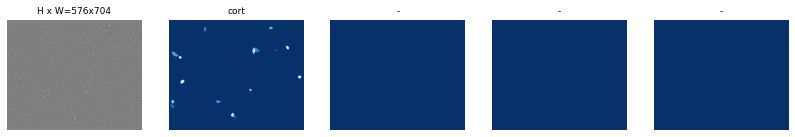

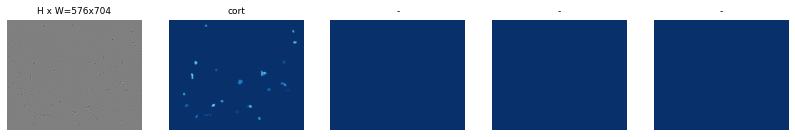

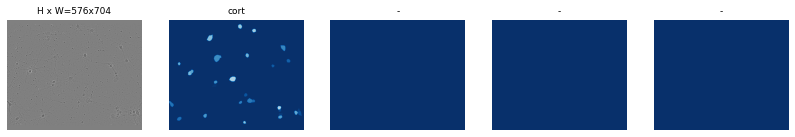

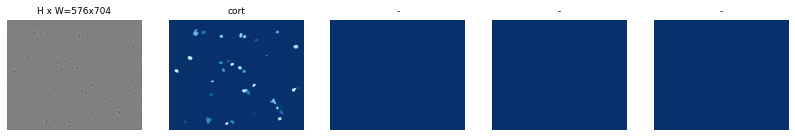

In [15]:
# Load an display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Bounding Boxes 

iamge_id  562 
image                    shape: (576, 704, 3)         min:    3.00000  max:  255.00000  uint8
mask                     shape: (576, 704, 30)        min:    0.00000  max:    1.00000  float64
class_ids                shape: (30,)                 min:    2.00000  max:    2.00000  int32
bbox                     shape: (30, 4)               min:   10.00000  max:  681.00000  int32


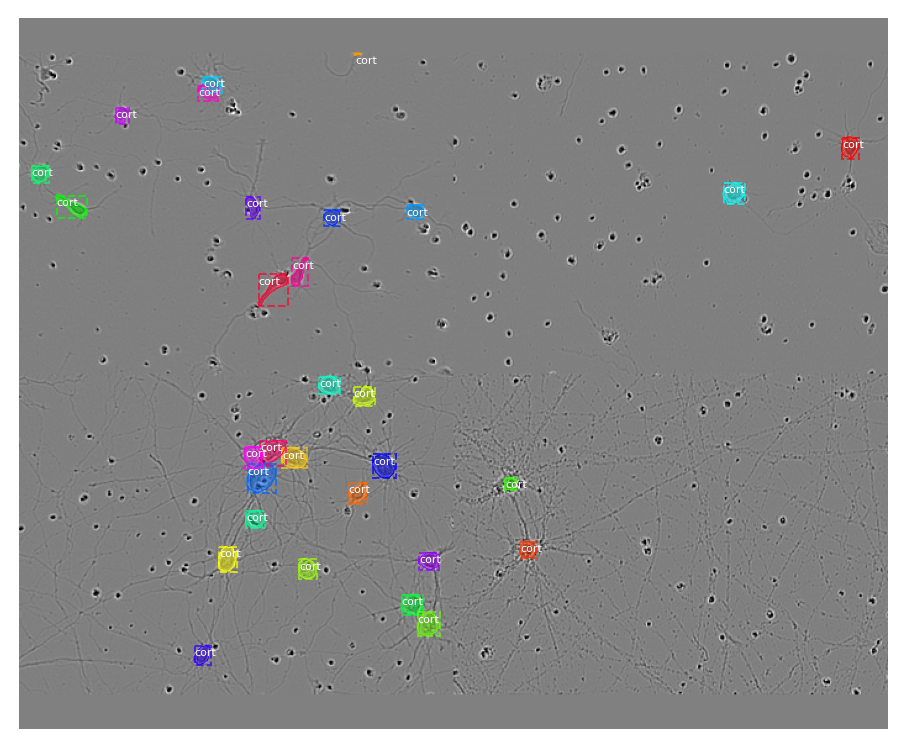

In [16]:
# Load random image and mask
image_id = np.random.choice(dataset_train.image_ids)
#image = dataset_train.load_image(image_id)
#mask, class_ids = dataset_train.load_mask(image_id)
image, mask, class_ids = dataset_train.mosaic(image_id)

# Compute bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print('iamge_id ', image_id, dataset_train.image_reference(image_id))
log('image', image)
log('mask', mask)
log('class_ids', class_ids)
log('bbox', bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

## Mini masks

image                    shape: (576, 704, 3)         min:    3.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 1346.00000  int64
class_ids                shape: (52,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (52, 4)               min:    0.00000  max:  704.00000  int32
mask                     shape: (576, 704, 52)        min:    0.00000  max:    1.00000  uint8


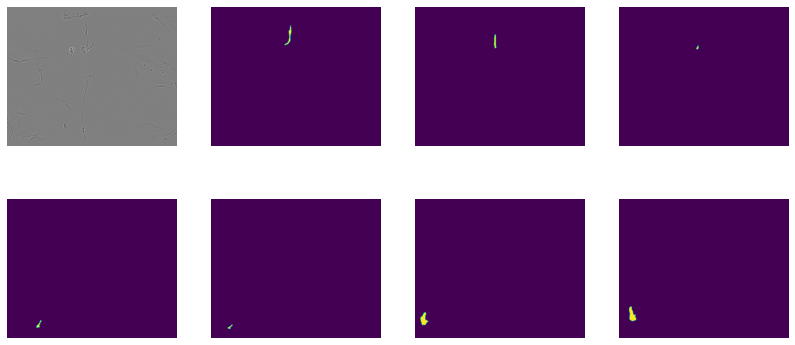

In [21]:
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, config, image_id)

log('image', image)
log('image_meta', image_meta)
log('class_ids', class_ids)
log('bbox', bbox)
log('mask', mask)

display_images([image]+[mask[..., i] for i in range(min(mask.shape[-1], 7))])

In [22]:
class MiniMaskConfig(CellConfig):
    USE_MINI_MASK = True
    
mm_config = MiniMaskConfig()
mm_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  704
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  576
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [704 704   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
LR_SCHEDULE                    False
MASK_POOL_SIZE        

/opt/anaconda3/lib/python3.8/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


mask                     shape: (56, 56, 52)          min:    0.00000  max:    1.00000  bool


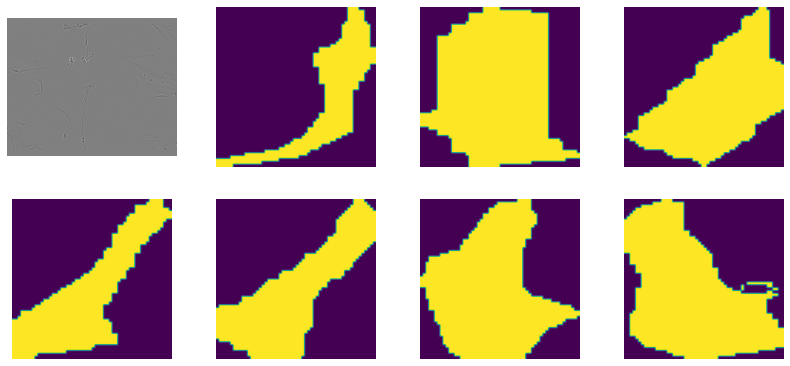

In [23]:
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, mm_config, image_id)
log('mask', mask)
display_images([image]+[mask[..., i] for i in range(min(mask.shape[-1], 7))])